#### Abstract

This project is done on liver disorders dataset taken from https://archive.ics.uci.edu/ml/datasets/Liver+Disorders
The goal of this project is to examine the dataset and try to group the dataset into two classes to determine if a person has liver disorder or not. By using the determined labels, I would then like to develop a model that would predict if a person has liver disorder or not based upon the results of the blood test.
The list of datamining tasks used are 
1) Feature construction - Principal component analysis 
2) Clustering - Spectral 
3) Classification - Naive Bayes 

#### 1.1. Importing the required Libraries

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#### 1.2. Method to calculate rand index (borrowed code from clustering hands on practice given by professor)

In [2]:
from scipy.special import comb 
def rand_index(S, T):

    Spairs = comb(np.bincount(S), 2).sum()
    Tpairs = comb(np.bincount(T), 2).sum()
    
    A = np.c_[(S, T)]
    
    f_11 = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(S))
    
    
    f_10 = Spairs - f_11
    f_01 = Tpairs - f_11
    f_00 = comb(len(A), 2) - f_11 - f_10 - f_01
    return (f_00 + f_11) / (f_00 + f_01 + f_10 + f_11)

#### 1.3. Exploratory Data Analysis

##### 1.3.1. Importing dataset and exploring number of datapoints and features

In [5]:
colnames=['mcv', 'alkphos', 'sgpt', 'sgot','gammagt','drinks_per_day','selector'] 
dataset=pd.read_csv('bupa.csv', delimiter=',',names=colnames, header=None)
print(dataset.shape)
print(dataset.head())

(345, 7)
   mcv  alkphos  sgpt  sgot  gammagt  drinks_per_day  selector
0   85       92    45    27       31             0.0         1
1   85       64    59    32       23             0.0         2
2   86       54    33    16       54             0.0         2
3   91       78    34    24       36             0.0         2
4   87       70    12    28       10             0.0         2


This dataset consists of data of 345 males. We have information of output of 5 different blood test of each of these individual along with the number of drinks per day each individual has. The dataset also has a selector column that was once used by initial BUPA reseachers to determine if the row is to be used as a training test or test data.

##### 1.3.2. Exploring covariance between the features

In [6]:
print(dataset.corr()) 


                     mcv   alkphos      sgpt      sgot   gammagt  \
mcv             1.000000  0.044103  0.147695  0.187765  0.222314   
alkphos         0.044103  1.000000  0.076208  0.146057  0.133140   
sgpt            0.147695  0.076208  1.000000  0.739675  0.503435   
sgot            0.187765  0.146057  0.739675  1.000000  0.527626   
gammagt         0.222314  0.133140  0.503435  0.527626  1.000000   
drinks_per_day  0.312680  0.100796  0.206848  0.279588  0.341224   
selector       -0.091070 -0.098050 -0.035009  0.157356  0.146393   

                drinks_per_day  selector  
mcv                   0.312680 -0.091070  
alkphos               0.100796 -0.098050  
sgpt                  0.206848 -0.035009  
sgot                  0.279588  0.157356  
gammagt               0.341224  0.146393  
drinks_per_day        1.000000 -0.022049  
selector             -0.022049  1.000000  


Since the values of covariance matrix are not high in most of the cases, we see that there is a minimum interaction between the features. Therfore there is no need to do the Principal component analysis to find the direction that captures maximum variance.

##### 1.3.3. Splicing predictor variables

In [7]:
liver_data = dataset.iloc[:,0:5]
print(liver_data.head())

   mcv  alkphos  sgpt  sgot  gammagt
0   85       92    45    27       31
1   85       64    59    32       23
2   86       54    33    16       54
3   91       78    34    24       36
4   87       70    12    28       10


##### 1.3.4. PCA for visualization

In [8]:
pca = PCA(3)  # project from 5 to 3 dimensions
projected = pca.fit_transform(liver_data)
print(projected.shape) 
print(np.array([pca.explained_variance_ratio_[:i].sum() for i in range(1, 4)]).round(2)) 

(345, 5)
(345, 3)
[0.72 0.85 0.98]


The shape of projected data is (345 X 3)
The cumulatavie percentage variance captured by first 3 principal components is 0.98

#### 1.4. Creating label variable using drinks_per_day feature

In [9]:
dataset['disorder'] = np.where(dataset['drinks_per_day']>3, 1, 0)
dataset.head()

,mcv,alkphos,sgpt,sgot,gammagt,drinks_per_day,selector,disorder
0,85,92,45,27,31,0.0,1,0
1,85,64,59,32,23,0.0,2,0
2,86,54,33,16,54,0.0,2,0
3,91,78,34,24,36,0.0,2,0
4,87,70,12,28,10,0.0,2,0


#### 1.5. Visualizing the two classes of data(with disorder and without disorder)

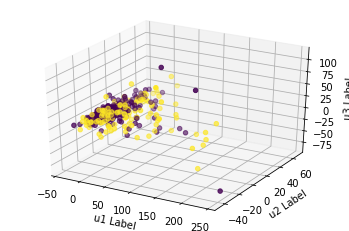

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=dataset.disorder, marker='o')

ax.set_xlabel('u1 Label')
ax.set_ylabel('u2 Label')
ax.set_zlabel('u3 Label')

plt.show()

#### 1.6. Creating a new dataframe with both predictor and response variables

In [11]:
new=pd.merge(pd.DataFrame(projected),dataset[['disorder','selector']], left_index=True, right_index=True)
new.columns=['u1','u2','u3','label','selector']
print(new.head())

          u1         u2         u3  label  selector
0  -0.697272  22.700584  15.230397      0         1
1  -5.472413  -4.335907  32.944637      0         2
2  12.955334 -17.482819  -4.971137      0         2
3  -0.563778   8.257226   3.427852      0         2
4 -31.566846   2.695028  -6.133727      0         2


#### 1.7. Clustering

##### 1.7.1. K-means clustering

0.5186046511627908


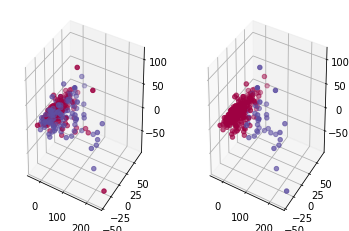

In [12]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=10);
#y_pred = kmeans.fit_predict(liver_data)
y_pred = kmeans.fit_predict(projected)
print(rand_index(y_pred, dataset.disorder))

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=dataset.disorder, marker='o',cmap='Spectral')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=y_pred, marker='o',cmap='Spectral')

plt.show()

From rand index value of 0.5186, we see that k-means clustering was not successful in differentiating the two classes. This is evident from the visualization too.

##### 1.7.2. Spectral clustering

C:\Users\prava\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


0.504314122008763


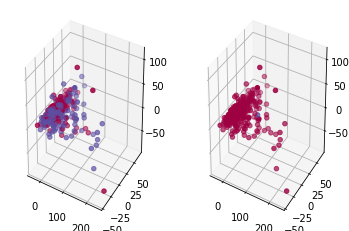

In [13]:
n_clusters = 2
spectral = SpectralClustering(n_clusters=n_clusters, random_state=10)
y_pred_spec = spectral.fit_predict(projected)
print(rand_index(y_pred_spec, dataset.disorder))
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=dataset.disorder, marker='o',cmap='Spectral')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=y_pred_spec, marker='o',cmap='Spectral')

plt.show()

From rand index value of 0.5043, we see that spectral clustering was not successful in differentiating the two classes. This is evident from the visualization too.

#### 1.8. Dividing data into train and test

Using the already available selector feature to divide the data into train and test

In [14]:
from sklearn.model_selection import cross_val_score, train_test_split

test_data=new[new['selector']==1]
test_data.drop(columns=['selector'],inplace=True)
test_data_X=test_data[['u1','u2','u3']]
test_data_Y=test_data[['label']]
print(test_data.shape)
train_data=new[new['selector']==2]
train_data.drop(columns=['selector'],inplace=True)
train_data_X=train_data[['u1','u2','u3']]
train_data_Y=train_data[['label']]
print(train_data.shape)

(145, 4)
(200, 4)


C:\Users\prava\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### 1.9. Classification

##### 1.9.1. Naive Bayes classifier

In [15]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model = gnb.fit(train_data_X, train_data_Y)
preds = gnb.predict(test_data_X)
print(accuracy_score(test_data_Y, preds))

0.6827586206896552


C:\Users\prava\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The prediction accuracy of Naive Bayes classifier is 68.27%

##### 1.9.2. Non-linear SVM( Support Vector Machine)

Since we see that in the current dimensional space, the classes are indistinguishable. Therefore we apply polynomial and rbf kernels to the data to see if the points become distinguishable in higher dimensional space.

In [16]:
from sklearn.svm import SVC
svm_poly = SVC(C=0.5, kernel='poly',degree=1, gamma = 'auto')
svm_poly_scores = cross_val_score(svm_poly, train_data_X, train_data_Y.values.ravel(), cv=10, scoring='accuracy')
print(svm_poly_scores.mean())
svm_poly = SVC(C=0.5, kernel='poly',degree=2, gamma = 'auto')
svm_poly_scores = cross_val_score(svm_poly, train_data_X, train_data_Y.values.ravel(), cv=10, scoring='accuracy')
print(svm_poly_scores.mean())
from sklearn.svm import SVC
svm_rbf = SVC(C = 0.5, kernel='rbf', gamma=0.01) 
svm_rbf_scores = cross_val_score(svm_rbf, train_data_X, train_data_Y.values.ravel(), cv=10, scoring='accuracy')
print(svm_rbf_scores.mean())
svm_rbf = SVC(C = 0.5, kernel='rbf', gamma=0.1) 
svm_rbf_scores = cross_val_score(svm_rbf, train_data_X, train_data_Y.values.ravel(), cv=10, scoring='accuracy')
print(svm_rbf_scores.mean())

0.53
0.5349999999999999
0.5650000000000001
0.5


The best accuracy we could get from non-linear SVM is 56.5%

#### 1.10. Limitations and future scope

* The accuracy of Naive Bayes classifier(68.27%) looks adequate in the context of amount of data available. 
* Since the domain is medical field, the results are expected to be very precise. 
* More datapoints could have helped in building a better classifier. 
* This project could be extended by using more modern methods like neural networks which could have helped in building better models.